In [1]:
import numpy as np
import json 
from utils import detokenize
import pathlib 
from transformers import AutoTokenizer
from ambiguous_parsing.eval.eval import rerender


/brtx/601-nvme1/estengel/miniconda3/envs/ambi/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:

def get_ex(amb_type, test_idx=0):

    test_time_path = pathlib.Path(f"/brtx/602-nvme1/estengel/ambiguous_parsing/logs/1.0/codegen-16B_lamp_no_context_all_{amb_type}_fol_0_test_eval_constrained_bs_5_np_full/")
    test_time_files = sorted(test_time_path.glob("model_outputs*")) 
    test_time_file = test_time_files[-1]
    forced_file = f"/brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-16B/{amb_type}_fol/outputs/test_eval.logits"
    gold_file_test = f"/brtx/602-nvme1/estengel/ambiguous_parsing/data/processed/{amb_type}_fol/test.jsonl"
    gold_file_eval = f"/brtx/602-nvme1/estengel/ambiguous_parsing/data/processed/{amb_type}_fol/test_eval.jsonl"


    with open(gold_file_test) as f1, open(gold_file_eval) as f2:
        gold_test = [json.loads(line) for line in f1]
        gold_eval = [json.loads(line) for line in f2]
        gold_eval_by_src = {d['utterance']:[] for d in gold_eval}
        for i, d in enumerate(gold_eval):
            gold_eval_by_src[d['utterance']].append((i,d))


    with open(test_time_file) as f1, open(forced_file) as f2:
        test_time = [json.loads(line) for line in f1]
        forced = [json.loads(line) for line in f2]
        assert(len(test_time) == len(gold_test))

    if test_idx == "first_correct": 
        test_idx = None
        for i, test_line in enumerate(test_time):
            top_pred = test_line['outputs'][0]
            try:
                top_pred = rerender(top_pred, is_fol=True)
            except:
                continue
            gold_lines = gold_eval_by_src[test_line['test_datum_natural']]
            gold_programs = [line[1]['plan'] for line in gold_lines]
            for p in gold_programs:
                p = rerender(p, is_fol=True)
                if p == top_pred:
                    test_idx = i 
                    break
        if test_idx is None:
            raise AssertionError("None correct")



    test_line = test_time[test_idx]

    eval_idxs, gold_eval_lines = zip(*gold_eval_by_src[test_line['test_datum_natural']])

    forced_line_0 = forced[eval_idxs[0]]
    forced_line_1 = forced[eval_idxs[1]]

    assert(test_line['test_datum_natural'] == forced_line_0['natural'])
    assert(test_line['test_datum_natural'] == forced_line_1['natural'])


    return test_line, forced_line_0, forced_line_1, gold_eval_lines

def get_new_logits(model_name, test_line):
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    logprobs = np.exp(test_line['results'][0]['logprobs'])
    tokens = test_line['results'][0]['tokens']

    new_logits, new_tokens = detokenize(tokenizer, "Ġ", logprobs, tokens, agg_fxn=np.min)
    return new_logits, new_tokens

In [27]:
from matplotlib import pyplot as plt 
from highlight_text import HighlightText, ax_text, fig_text
import matplotlib as mpl

def comparison(new_tokens, 
        alt_tokens, 
        new_logits,
        label,
        ax0, ax1):

        new_tokens = [label, "(a):"] + new_tokens
        # Prepend 2 0s to logits np array
        label_props = [{"color": "000000", "weight": "bold"} for i in range(2)]

        alt_tokens = [label, "(b):"] + alt_tokens


        cmap = mpl.colormaps["Blues"]
        bbox_pad = 1.5
        bboxprops = {'linewidth': 0, 'pad': bbox_pad}

        upper = ax_text(s=" ".join([f"<{x}>" for x in new_tokens]),
                x=0,
                y=0.4,
                va='center',
                highlight_textprops=label_props + [{'color': 'w', 'weight': 'bold', 'bbox': {'facecolor':cmap(logit), **bboxprops}}  for logit in new_logits],
                fontname='DejaVu Sans Mono',
                fontsize = 16,
                ax=ax0
        )

        lower = ax_text(s=" ".join([f"<{x}>" for x in alt_tokens]),
                x=0,
                y=0.4,
                va='center',
                highlight_textprops=[{'color': '000000', 'weight': 'bold', 'bbox': {'facecolor':"w", **bboxprops}}  for tok in alt_tokens],
                fontname='DejaVu Sans Mono',
                fontsize = 16,
                ax=ax1
        )

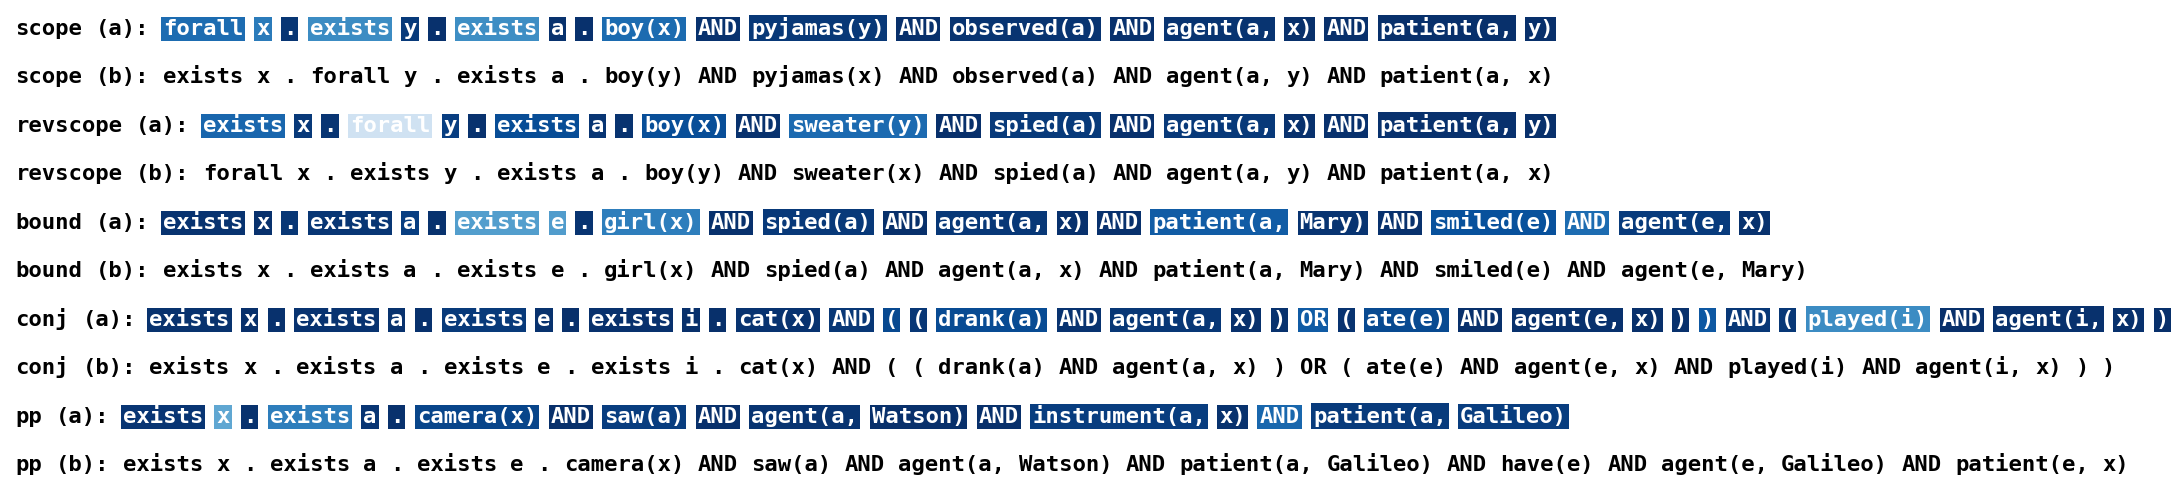

In [28]:

layout = [
        # ['scope_label'],
        ['scope_upper'],
        ['scope_lower'],
        # ['revscope_label'],
        ['revscope_upper'],
        ['revscope_lower'],
        # ['bound_label'],
        ['bound_upper'],
        ['bound_lower'],
        # ['conj_label'],
        ['conj_upper'],
        ['conj_lower'],
        # ['pp_label'],
        ['pp_upper'],
        ['pp_lower']]

fig, axd = plt.subplot_mosaic(layout,
                        constrained_layout=False,
                        figsize=(21.5, 5),
                        gridspec_kw={'height_ratios': [0.1 for _ in range(len(layout))]})

test_line, forced_line_0, forced_line_1, gold_eval_lines = get_ex("scope", "first_correct")
new_logits, new_tokens = get_new_logits("/brtx/601-nvme1/estengel/.cache/codegen-16B/", test_line)
gold_eval_line_0 = [x for x in gold_eval_lines if str(x['template_idx']) == '0'][0]
alt_tokens = gold_eval_line_0['plan'].split(" ")
comparison(new_tokens, alt_tokens, new_logits, label = "scope", 
        # ax_label=axd['scope_label'], 
        ax0=axd['scope_upper'], ax1=axd['scope_lower'])



test_line, forced_line_0, forced_line_1, gold_eval_lines = get_ex("revscope", "first_correct")
new_logits, new_tokens = get_new_logits("/brtx/601-nvme1/estengel/.cache/codegen-16B/", test_line)
gold_eval_line_0 = [x for x in gold_eval_lines if str(x['template_idx']) == '0'][0]
gold_eval_line_1 = [x for x in gold_eval_lines if str(x['template_idx']) == '1'][0]
alt_tokens = gold_eval_line_1['plan'].split(" ")
comparison(new_tokens, alt_tokens, new_logits, label = "revscope", 
        #    ax_label=axd['revscope_label'], 
           ax0=axd['revscope_upper'], ax1=axd['revscope_lower'])




test_line, forced_line_0, forced_line_1, gold_eval_lines = get_ex("bound",  "first_correct")
new_logits, new_tokens = get_new_logits("/brtx/601-nvme1/estengel/.cache/codegen-16B/", test_line)
gold_eval_line_0 = [x for x in gold_eval_lines if str(x['template_idx']) == '0'][0]
gold_eval_line_1 = [x for x in gold_eval_lines if str(x['template_idx']) == '1'][0]
alt_tokens = gold_eval_line_1['plan'].split(" ")
comparison(new_tokens, alt_tokens, new_logits, label='bound', 
        #    ax_label=axd['bound_label'], 
           ax0=axd['bound_upper'], ax1=axd['bound_lower'])




test_line, forced_line_0, forced_line_1, gold_eval_lines = get_ex("conj",  "first_correct")
new_logits, new_tokens = get_new_logits("/brtx/601-nvme1/estengel/.cache/codegen-16B/", test_line)
gold_eval_line_0 = [x for x in gold_eval_lines if str(x['template_idx']) == '0'][0]
gold_eval_line_1 = [x for x in gold_eval_lines if str(x['template_idx']) == '1'][0]
alt_tokens = gold_eval_line_1['plan'].split(" ")
comparison(new_tokens, alt_tokens, new_logits, label='conj', 
        #    ax_label=axd['conj_label'], 
           ax0=axd['conj_upper'], ax1=axd['conj_lower'])



test_line, forced_line_0, forced_line_1, gold_eval_lines = get_ex("pp", "first_correct")
new_logits, new_tokens = get_new_logits("/brtx/601-nvme1/estengel/.cache/codegen-16B/", test_line)
gold_eval_line_0 = [x for x in gold_eval_lines if str(x['template_idx']) == '0'][0]
alt_tokens = gold_eval_line_0['plan'].split(" ")
comparison(new_tokens, alt_tokens, new_logits, label='pp', 
        #    ax_label=axd['pp_label'], 
           ax0=axd['pp_upper'], ax1=axd['pp_lower'])


axd['scope_upper'].axis('off')
axd['scope_lower'].axis('off')
axd['revscope_upper'].axis('off')
axd['revscope_lower'].axis('off')
axd['bound_upper'].axis('off')
axd['bound_lower'].axis('off')
axd['conj_upper'].axis('off')
axd['conj_lower'].axis('off')
axd['pp_upper'].axis('off')
axd['pp_lower'].axis('off')


plt.tight_layout()
plt.savefig("/home/estengel/papers/ambiguous-parsing-2023/figures/text_heatmap.pdf") 